Train a classifier and generate GradCAM's highlighting regions of each brain image important for diagnosis.

In [1]:
import sys
sys.path.append('../')
from medl.tfutils import set_gpu
set_gpu(1, 0.5)

2022-01-25 14:46:23.372833: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-01-25 14:46:26.037444: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-25 14:46:26.049140: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2399885000 Hz
2022-01-25 14:46:26.052286: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555559436510 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-25 14:46:26.052306: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-01-25 14:46:26.055774: I tensorflow/stream_executor/platform/default/d

In [2]:
import os
import cv2
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt

import tensorflow as tf
from medl.misc import expand_data_path, expand_results_path
from main import get_model

2022-01-25 14:46:58.899323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:82:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-01-25 14:46:58.899372: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-01-25 14:46:58.899405: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-01-25 14:46:58.899422: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-01-25 14:46:58.899438: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
2022-01-25 14:46:58.899453: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuso

Select model type and output directory

In [3]:
strModelType = 'mixedeffects'
strOutputDir = expand_results_path('ad_classifier', make=True)

Load data

In [4]:
# Data directory
strDataDir = expand_data_path('ADNI23_sMRI/right_hippocampus_slices_2pctnorm/coronal_MNI-6_numpy/12sites/split00')
dictDataTrain = np.load(os.path.join(strDataDir, 'data_train.npz'))
dictDataVal = np.load(os.path.join(strDataDir, 'data_val.npz'))
dictDataTest = np.load(os.path.join(strDataDir, 'data_test.npz'))
dictDataUnseen = np.load(os.path.join(strDataDir, 'data_unseen.npz'))

# Weight each class by 1 - class frequency
dictClassWeights = {0.: dictDataTrain['label'].mean(),
                    1.: 1 - dictDataTrain['label'].mean()}

if strModelType == 'conventional':    
    train_in = dictDataTrain['images']
    val_in = dictDataVal['images']
    test_in = dictDataTest['images']
    unseen_in = dictDataUnseen['images']
else:
    train_in = (dictDataTrain['images'], dictDataTrain['cluster'])
    val_in = (dictDataVal['images'], dictDataVal['cluster'])
    test_in = (dictDataTest['images'], dictDataTest['cluster'])
    unseen_in = (dictDataUnseen['images'], dictDataUnseen['cluster'])

Train model

In [5]:
model = get_model(strModelType, n_clusters=dictDataTrain['siteorder'].shape[0])
        
lsCallbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_auroc', mode='max',
                                                patience=5, 
                                                restore_best_weights=True)]
    
model.fit(x=train_in,
        y=dictDataTrain['label'],
        batch_size=32,
        epochs=20,
        verbose=1,
        class_weight=dictClassWeights,
        callbacks=lsCallbacks,
        validation_data=(val_in, dictDataVal['label']))

Epoch 1/20


2022-01-25 14:47:01.477449: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-01-25 14:47:11.873399: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-01-25 14:47:12.267968: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


10/10 [==============================] - 5s 522ms/step - class_loss: 0.2053 - gen_loss: 0.7257 - adv_loss: 0.7306 - kld: 16.3451 - total_loss: 16.6230 - auroc: 0.5014 - val_class_loss: 0.6772 - val_gen_loss: 2.4293 - val_adv_loss: 0.0000e+00 - val_kld: 16.3159 - val_total_loss: 17.2361 - val_auroc: 0.7069
Epoch 2/20
10/10 [==============================] - 3s 330ms/step - class_loss: 0.2026 - gen_loss: 0.6867 - adv_loss: 0.7062 - kld: 16.3516 - total_loss: 16.6229 - auroc: 0.4951 - val_class_loss: 0.6478 - val_gen_loss: 2.4292 - val_adv_loss: 0.0000e+00 - val_kld: 16.3376 - val_total_loss: 17.2284 - val_auroc: 0.7436
Epoch 3/20
10/10 [==============================] - 3s 329ms/step - class_loss: 0.2034 - gen_loss: 0.6911 - adv_loss: 0.7137 - kld: 16.3054 - total_loss: 16.5778 - auroc: 0.5285 - val_class_loss: 0.6867 - val_gen_loss: 2.4762 - val_adv_loss: 0.0000e+00 - val_kld: 16.3653 - val_total_loss: 17.2996 - val_auroc: 0.7485
Epoch 4/20
10/10 [==============================] - 3s 32

GradCAM functions

In [7]:
def gradcam(inputs):
    
    with tf.GradientTape() as gt:
        if strModelType == 'adversarial':
            outputs = model.classifier.call(inputs, return_layer_activations=True)
        else:
            outputs = model.call(inputs, return_layer_activations=True)
        pred = outputs[-1]
        conv = outputs[-4] #2nd to last convolutional layer output

    grads = gt.gradient(pred, conv)
    gradsPooled = tf.reduce_max(grads, axis=(0, 1, 2))
    heatmap = conv[0] @ gradsPooled[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    arrHeatmap = tf.maximum(heatmap, 0).numpy()
    arrHeatmap -= arrHeatmap.min()
    arrHeatmap /= arrHeatmap.max()
    return arrHeatmap
 
def superimpose(img, heatmap):
    # Superimpose the heatmap on the original image using the jet colormap.
    heatmap = np.uint8(255 * heatmap)
        
    jet = cm.get_cmap('jet')
    arrColors = jet(np.arange(256))[:, :3]
    arrHeatmapJet = arrColors[heatmap]
    arrHeatmapJet = cv2.resize(arrHeatmapJet, img.squeeze().shape)

    arrSuper = arrHeatmapJet * 0.75 + img    
    return arrSuper.squeeze() / arrSuper.max()

Create GradCAM's for 3 images from each site.

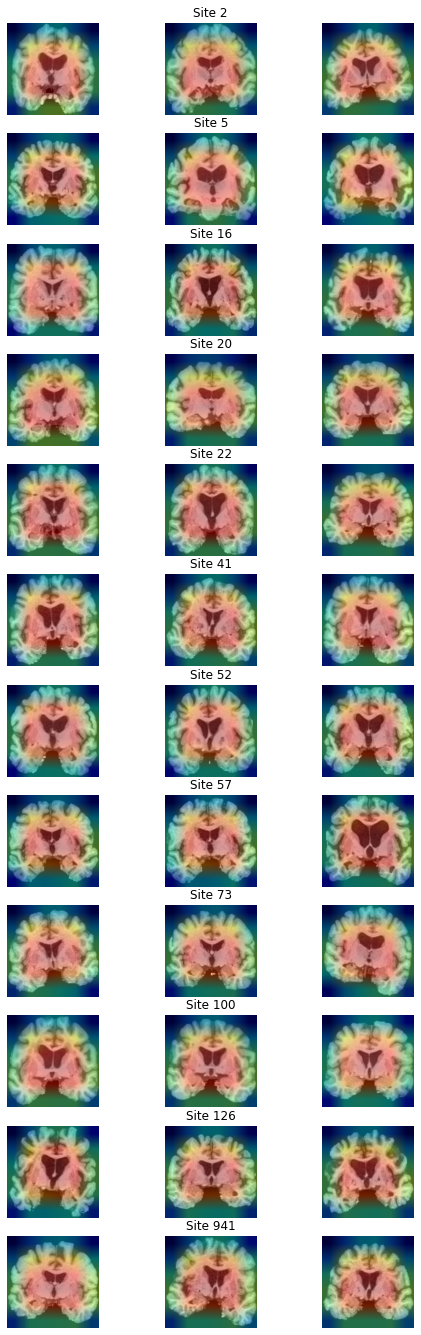

In [8]:
nSites = dictDataTrain['siteorder'].shape[0]
nImagesPerSite = 3
fig, ax = plt.subplots( nSites, nImagesPerSite, figsize=(8, nSites*2))
for iSite in range(nSites):
    site = dictDataTrain['siteorder'][iSite]
    arrSiteImages = dictDataTrain['images'][dictDataTrain['cluster'][:, iSite] == 1]
    np.random.seed(38)
    arrSelectIdx = np.random.choice(np.arange(arrSiteImages.shape[0]), nImagesPerSite)
    for iImage in range(nImagesPerSite):
        img = arrSiteImages[arrSelectIdx[iImage],]
        if strModelType in ['clusterinput', 'randomeffects', 'mixedeffects']:
            z = np.zeros((1, nSites), dtype=np.float32)
            z[:, iSite] = 1
            cam = gradcam((np.expand_dims(img, 0), z))
        else:
            cam = gradcam(np.expand_dims(img, 0))
        overlaid = superimpose(img, cam)
        ax[iSite, iImage].imshow(overlaid)
        ax[iSite, iImage].axis('off')
        
    ax[iSite, 1].set_title(f'Site {site}')

fig.savefig(os.path.join(strOutputDir, strModelType + '_gradcam.png'))
fig.savefig(os.path.join(strOutputDir, strModelType + '_gradcam.svg'))